In [39]:
import requests
import datetime
import re
import socket
import ssl
import urllib.request

import regex
import whois
from bs4 import BeautifulSoup
from tldextract import extract

In [40]:
def generate_data_set(url):

    data_set = []

    # Converts the given URL into standard format
    if not re.match(r"^https?", url):
        url = "http://" + url
    
    # Stores the response of the given URL
    try:
        response = requests.get(url)
    except:
        response = ""

    # Extracts domain from the given URL
    domain = re.findall(r"://([^/]+)/?", url)[0]

    # Requests all the information about the domain
    whois_response = requests.get("https://www.whois.com/whois/"+domain)

    rank_checker_response = requests.post("https://www.checkpagerank.net/index.php", {
        "name": domain
    })

    # Extracts global rank of the website
    try:
        global_rank = int(re.findall(r"Global Rank: ([0-9]+)", rank_checker_response.text)[0])
    except:
        global_rank = -1

    def url_having_ip(url):
        # using regular function
        symbol = regex.findall(r'(http((s)?)://)((((\d)+).)*)((\w)+)(/((\w)+))?', url)
        if (len(symbol) != 0):
            having_ip = 1  # phishing
        else:
            having_ip = -1  # legitimate
            return (having_ip)
        return 0

    def url_length(url):
        length = len(url)
        if (length < 54):
            return -1
        elif (54 <= length <= 75):
            return 0
        else:
            return 1

    def url_short(url):
        if re.findall("goo.gl|bit.ly", url):
            return 1
        else:
            return -1

    def having_at_symbol(url):
        symbol = regex.findall(r'@', url)
        if (len(symbol) == 0):
            return -1
        else:
            return 1

    def doubleSlash(url):
        if re.findall(r"[^https?:]//", url):
            return -1
        else:
            return 1

    def prefix_suffix(url):
        subDomain, domain, suffix = extract(url)
        if (domain.count('-')):
            return 1
        else:
            return -1

    def sub_domain(url):
        subDomain, domain, suffix = extract(url)
        if (subDomain.count('.') == 0):
            return -1
        elif (subDomain.count('.') == 1):
            return 0
        else:
            return 1

    def SSLfinal_State(url):
        try:
            # check wheather contains https
            if (regex.search('^https', url)):
                usehttps = 1
            else:
                usehttps = 0
            # getting the certificate issuer to later compare with trusted issuer
            # getting host name
            subDomain, domain, suffix = extract(url)
            host_name = domain + "." + suffix
            context = ssl.create_default_context()
            sct = context.wrap_socket(socket.socket(), server_hostname=host_name)
            sct.connect((host_name, 443))
            certificate = sct.getpeercert()
            issuer = dict(x[0] for x in certificate['issuer'])
            certificate_Auth = str(issuer['commonName'])
            certificate_Auth = certificate_Auth.split()
            if (certificate_Auth[0] == "Network" or certificate_Auth == "Deutsche"):
                certificate_Auth = certificate_Auth[0] + " " + certificate_Auth[1]
            else:
                certificate_Auth = certificate_Auth[0]
            trusted_Auth = ['Comodo', 'Symantec', 'GoDaddy', 'GlobalSign', 'DigiCert', 'StartCom', 'Entrust', 'Verizon',
                            'Trustwave', 'Unizeto', 'Buypass', 'QuoVadis', 'Deutsche Telekom', 'Network Solutions',
                            'SwissSign', 'IdenTrust', 'Secom', 'TWCA', 'GeoTrust', 'Thawte', 'Doster', 'VeriSign']
            # getting age of certificate
            startingDate = str(certificate['notBefore'])
            endingDate = str(certificate['notAfter'])
            startingYear = int(startingDate.split()[3])
            endingYear = int(endingDate.split()[3])
            Age_of_certificate = endingYear - startingYear

            # checking final conditions
            if ((usehttps == 1) and (certificate_Auth in trusted_Auth) and (Age_of_certificate >= 1)):
                return -1  # legitimate
            elif ((usehttps == 1) and (certificate_Auth not in trusted_Auth)):
                return 0  # suspicious
            else:
                return 1  # phishing

        except Exception as e:

            return 1

    def domain_registration(url):
        try:
            w = whois.whois(url)
            updated = w.updated_date
            exp = w.expiration_date
            length = (exp[0] - updated[0]).days
            if (length <= 365):
                return 1
            else:
                return -1
        except:
            return 0

    def favicon(url):
        # ongoing
        return 0

    def port(url):
        try:
            port = domain.split(":")[1]
            if port:
                return 1
            else:
                return -1
        except:
            return -1

    def https_token(url):
        subDomain, domain, suffix = extract(url)
        host = subDomain + '.' + domain + '.' + suffix
        if (host.count('https')):  # attacker can trick by putting https in domain part
            return 1
        else:
            return -1

    def request_url(url):
        try:
            subDomain, domain, suffix = extract(url)
            websiteDomain = domain

            opener = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(opener, 'lxml')
            imgs = soup.findAll('img', src=True)
            total = len(imgs)

            linked_to_same = 0
            avg = 0
            for image in imgs:
                subDomain, domain, suffix = extract(image['src'])
                imageDomain = domain
                if (websiteDomain == imageDomain or imageDomain == ''):
                    linked_to_same = linked_to_same + 1
            vids = soup.findAll('video', src=True)
            total = total + len(vids)

            for video in vids:
                subDomain, domain, suffix = extract(video['src'])
                vidDomain = domain
                if (websiteDomain == vidDomain or vidDomain == ''):
                    linked_to_same = linked_to_same + 1
            linked_outside = total - linked_to_same
            if (total != 0):
                avg = linked_outside / total

            if (avg < 0.22):
                return -1
            elif (0.22 <= avg <= 0.61):
                return 0
            else:
                return 1
        except:
            return 0

    def url_of_anchor(url):
        try:
            subDomain, domain, suffix = extract(url)
            websiteDomain = domain

            opener = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(opener, 'lxml')
            anchors = soup.findAll('a', href=True)
            total = len(anchors)
            linked_to_same = 0
            avg = 0
            for anchor in anchors:
                subDomain, domain, suffix = extract(anchor['href'])
                anchorDomain = domain
                if (websiteDomain == anchorDomain or anchorDomain == ''):
                    linked_to_same = linked_to_same + 1
            linked_outside = total - linked_to_same
            if (total != 0):
                avg = linked_outside / total

            if (avg < 0.31):
                return -1
            elif (0.31 <= avg <= 0.67):
                return 0
            else:
                return 1
        except:
            return 0

    def Links_in_tags(url):
        try:
            opener = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(opener, 'lxml')

            no_of_meta = 0
            no_of_link = 0
            no_of_script = 0
            anchors = 0
            avg = 0
            for meta in soup.find_all('meta'):
                no_of_meta = no_of_meta + 1
            for link in soup.find_all('link'):
                no_of_link = no_of_link + 1
            for script in soup.find_all('script'):
                no_of_script = no_of_script + 1
            for anchor in soup.find_all('a'):
                anchors = anchors + 1
            total = no_of_meta + no_of_link + no_of_script + anchors
            tags = no_of_meta + no_of_link + no_of_script
            if (total != 0):
                avg = tags / total

            if (avg < 0.25):
                return -1
            elif (0.25 <= avg <= 0.81):
                return 0
            else:
                return 1
        except:
            return 0

    def sfh(url):
        # ongoing
        return 0

    def email_submit(url):
        try:
            opener = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(opener, 'lxml')
            if (soup.find('mailto:')):
                return 1
            else:
                return -1
        except:
            return 0

    def abnormal_url(url):
        return 0;

    def redirect(url):
        if len(response.history) <= 1:
            return -1
        elif len(response.history) <= 4:
            return 0
        else:
            return 1

    def on_mouseover(url):
        if re.findall("<script>.+onmouseover.+</script>", response.text):
            return 1
        else:
            return -1

    def popup(url):
        if re.findall(r"alert\(", response.text):
            return 1
        else:
            return -1

    def iframe(url):
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            return 1
        else:
            return -1

    def age_of_domain(url):
        try:
            w = whois.whois(url)
            start_date = w.creation_date
            current_date = datetime.datetime.now()
            age = (current_date - start_date[0]).days
            if (age >= 180):
                return -1
            else:
                return 1
        except Exception as e:
            print(e)
            return 0

    def dns(url):
        # ongoing
        return 0

    def web_traffic(url):
        try:
            if global_rank > 0 and global_rank < 100000:
                return -1
            else:
                return 1
        except:
            return 1

    def page_rank(url):
        try:
            if global_rank > 0 and global_rank < 100000:
                return -1
            else:
                return 1
        except:
            return 1

    def google_index(url):
        try:
            if global_rank > 0 and global_rank < 100000:
                return -1
            else:
                return 1
        except:
            return 1

    def links_pointing(url):
        number_of_links = len(re.findall(r"<a href=", response.text))
        if number_of_links == 0:
            return 1
        elif number_of_links <= 2:
            return 0
        else:
            return -1

    def rightClick(url):
        if re.findall(r"event.button ?== ?2", response.text):
            return 1
        else:
            return -1
    def statistical(url):
        # ongoing
        return -1

    check = [[url_having_ip(url), url_length(url), url_short(url), having_at_symbol(url),
              doubleSlash(url), prefix_suffix(url), sub_domain(url), SSLfinal_State(url),
              domain_registration(url), favicon(url), port(url), https_token(url), request_url(url),
              url_of_anchor(url), Links_in_tags(url), sfh(url), email_submit(url), abnormal_url(url),
              redirect(url), on_mouseover(url), rightClick(url), popup(url), iframe(url),
              age_of_domain(url), dns(url), web_traffic(url), page_rank(url), google_index(url),
              links_pointing(url), statistical(url)]]
    return check


In [41]:
def main(url):
    return generate_data_set(url)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
#from sklearn.externals import joblib



In [43]:

#importing the dataset
dataset = pd.read_csv("phishcoop.csv")
dataset = dataset.drop('id', 1) #removing unwanted column

x = dataset.iloc[ : , :-1].values
y = dataset.iloc[:, -1:].values
print(y)

[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
#from sklearn.externals import joblib
#spliting the dataset into training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25, random_state =0 )

#fitting logistic regression 
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

#predicting the tests set result
y_pred = classifier.predict(x_test)

#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
score = classifier.score(x_test, y_test)
print(score*100,"%")

[[1120  129]
 [  84 1431]]
92.29377713458756 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


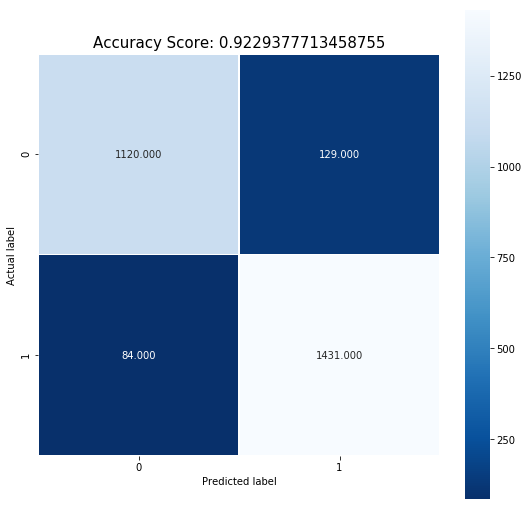

In [45]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [46]:
#pickle file joblib
#joblib.dump(classifier, 'final_models/rf_final.pkl')



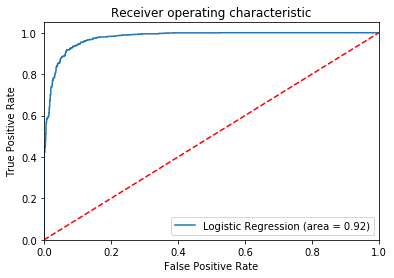

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


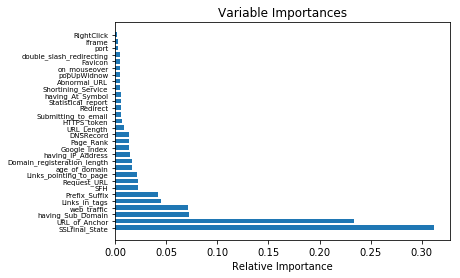

In [48]:
#-------------plotting variable importance
plt.title("Variable Importances")
plt.barh(np.arange(len(names)), sorted_importances, height = 0.7)
plt.yticks(np.arange(len(names)), names[indices], fontsize=7)
plt.xlabel('Relative Importance')
plt.show()

In [57]:
print("enter url")
url = input()

#checking and predicting
checkprediction = main(url)
#checkprediction=[[0, -1, -1, -1, 1, 1, -1, 1, 0, 0, -1, -1, 1, 1, 0, 0, -1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 1, 1, -1, -1]]
prediction = classifier.predict(checkprediction)
if prediction==1:
    print("Warning The website is harmfull for you")
else:
    print("COOL! You can excess the website")
    print(url)

enter url
http://ujljw.fpi.teckhead.com/fus/?vMQplMMaav
timed out
Warning The website is harmfull for you
